In [1]:
import numpy as np

class DisjointSet(object):
	def __init__(self,items):
		self._disjoint_set = list()
		if items:
			for item in set(items):
				self._disjoint_set.append([item])

	def _get_index(self,item):
		for s in self._disjoint_set:
			for _item in s:
				if _item == item:
					return self._disjoint_set.index(s)
		return None

	def find(self,item):
		for s in self._disjoint_set:
			if item in s:
				return s
		return None

	def find_set(self,item):

		s = self._get_index(item)

		return s if s is not None else None 

	def union(self,item1,item2):
		i = self._get_index(item1)
		j = self._get_index(item2)
		if i != j:
			self._disjoint_set[i] += self._disjoint_set[j]
			del self._disjoint_set[j]
	
	def get(self):
		return self._disjoint_set

In [2]:
class State:
    def __init__(self, name=None):
        self.name = str(name)

    def __repr__(self):
        return 'State(' + self.name + ")"

In [3]:
from graphviz import Source

In [21]:
from copy import copy
from collections import defaultdict

def count(string, array):
    res = 0
    for a in array:
        res += string.count(a)
    return res
class ReGrammar:
    def __init__(self, V, T, P, S='S'):
        self.P = P
        self.V = V
        self.T = T
        for v in self.V + self.T:
            if len(v) > 1:
                raise Exception('Xin hãy chọn chữ cái có độ dài = 1')
        self.S = S
    
    @classmethod
    def from_text(cls, text):
        text = text.strip()
        lines = text.split('\n')
        V = lines[0].split(' ')
        T = lines[1].split(' ')
        S = lines[2]
        P = defaultdict(list)
        for line in lines[3:]:
            line_splitted = line.split('->')
            v = line_splitted[0].strip()
            P[v].extend([r.strip() for r in line_splitted[1].split('|')])
        return cls(V, T, P, S)

    def is_left_linear(self):
        f = True
        for key in self.P.keys():
            for r in self.P[key]:
                if (count(r, self.V) == 1 and r[0] not in self.V) or count(r, self.V) > 1:
                    f = False
                    break
        return f
    
    def is_right_linear(self):
        f = True
        for key in self.P.keys():
            for r in self.P[key]:
                if (count(r, self.V) == 1 and r[-1] not in self.V) or count(r, self.V) > 1:
                    f = False
                    break
        return f

    def is_regular_grammar(self):
        return self.is_left_linear() or self.is_right_linear()

    def to_right_linear(self):
        if not self.is_left_linear:
            raise Exception("Không chuyển được =(")
        elif self.is_right_linear:
            return copy(self)
        new_P = defaultdict(list)
        new_start = False
        for key in self.P.keys():
            for rule in self.P[key]:
                if self.S in rule:
                    new_start = True
                    break
        P = copy(self.P)
        V = self.V[:]
        if new_start:
            S = 'S_0'
            V.append('S_0')
            P['S_0'].append(self.S)
        else:
            S = self.S
        for key in P.keys():
            for rule in P[key]:
                if count(rule, V) == 0 and key == S:
                    new_P[key].append(rule)
                elif count(rule, V) == 0:
                    new_P[S].append(rule + key)
                elif key == S and rule[0] in V:
                    new_P[rule[0]].append(rule[1:] if rule[1:] != '' else 'ε')
                elif rule[0] in V:
                    new_P[rule[0]].append((rule[1:] if rule[1:] != '' else 'ε') + key)
                else:
                    new_P[key].append(rule)
        reg = ReGrammar(V, self.T, new_P, self.S)
        reg.S = S
        return reg
    
    def to_string(self):
        string_result = ' '.join(self.V) + '\n' + ' '.join(self.T) + '\n' + self.S + '\n'        
        for key in self.P.keys():
            if len(self.P[key]) > 0:
                string_result += (key + ' -> ' + '|'.join(self.P[key]) + '\n')
        return string_result
    
    def to_nfa(self):
        #from NFA import NFA
        #from State import State
        if not self.is_regular_grammar():
            raise Exception('Văn phạm này không phải văn phạm chính quy')
        if self.is_left_linear():
            self = self.to_right_linear()
        alphabet = self.T
        Q = []
        for v in self.V:
            state = State()
            state.name = v
            Q.append(state)
            if v == self.S:
                init_state = state
        final_state = State()
        final_state.name = 'ε'
        Q.append(final_state)
        final_states = [final_state]
        middle_states = []
        table = defaultdict(dict)
        for s in Q:
            for c in alphabet + ['ε']:
                table[s][c] = set()
        for key in self.P.keys():
            for rule in self.P[key]:
                if rule[-1] in self.V:
                     for s in Q:
                         if s.name == key:
                             start = s
                         if s.name == rule[-1]:
                             des = s
                             w = rule[:-1]
                             
                else:
                    for s in Q:
                        if s.name == key:
                             start = s
                        if s.name == 'ε':
                            des = s
                            w = rule
                path = [start]
                for _ in range(len(w) - 1):
                    n_state = State()
                    path.append(n_state)
                    middle_states.append(n_state)
                    for c in alphabet + ['ε']:
                        table[n_state][c] = set()
                path.append(des)
                for idx, c in enumerate(w):
                    table[path[idx]][c].add(path[idx+1])
        Q.extend(middle_states)
        nfa = NFA(Q, alphabet, init_state, final_states, table)
        nfa.rename_states()
        return nfa

In [5]:
from collections import deque

class Regex:
    op = ['.', '+', '*']
    p = ['(', ')']
    pre = [2, 1, 2]
    def __init__(self, string, alphabet):
        self.string = string
        self.parsed_string = self.parse()
        self.alphabet = alphabet

    def __repr__(self):
        return self.string
    
    def parse(self):
        s = self.string.replace(' ', '')
        queue = deque()
        stack = list()
        for w in s:
            if w not in self.op+self.p:
                queue.append(w)
            else:
                if w == '(':
                    stack.append(w)
                elif w == ')':
                    while len(stack) != 0 and stack[-1] != '(':
                        queue.append(stack.pop())
                    stack.pop()
                else:
                    while len(stack) != 0 and ((stack[-1] in self.op and self.pre[self.op.index(stack[-1])] > self.pre[self.op.index(w)]) or (stack[-1] == '*')):
                        queue.append(stack.pop())
                    stack.append(w)
        queue.extend(stack[::-1])
        return queue
    
    
    def to_nfa(self):
        stack = list() 
        for w in self.parsed_string:
            if w not in self.op:
                nfa = NFA.single_char(self.alphabet, w)
                nfa.rename_states()
                stack.append(nfa)
            elif w == '+':
                nfa_2 = stack.pop()
                nfa_1 = stack.pop()
                stack.append(NFA.union(nfa_1, nfa_2))
            elif w == '.':
                nfa_2 = stack.pop()
                nfa_1 = stack.pop()
                stack.append(NFA.concatenation(nfa_1, nfa_2))
            elif w == '*':
                nfa_1 = stack.pop()
                stack.append(NFA.star(nfa_1))
        result = stack.pop()
        return result

In [6]:
class DFA:
    def __init__(self, Q, alphabet, init_state, final_states, table):
        self.Q = Q
        self.alphabet = alphabet
        self.init_state = init_state
        self.final_states = final_states
        self.table = table
    
    @classmethod
    def from_text(cls, text):
        text = text.strip()
        lines = text.split('\n')
        Q = lines[0].split(' ')
        states = []
        for q in Q:
            state = State(q)
            states.append(state)
        alphabet = lines[1].split(' ')
        init_state = states[int(lines[2])]
        final_states = [states[int(index)] for index in lines[3].split(' ')]
        table = dict()
        for s in states:
            table[s] = dict()
            for c in alphabet:
                table[s][c] = None
        for line in lines[4:]:
            s, c, d = line.split(' ')
            s = int(s)
            d = int(d)
            table[states[s]][c] = states[d]
        return cls(states, alphabet, init_state, final_states, table)
    
    def draw(self):
        string = """digraph G{
label = """ + '"' + '' + '"' + """
rankdir = LR;
node [shape = circle];
node [shape = doublecircle]; 
"""
        s = [self.init_state]
        edge_set = set()
        for e in self.final_states:
            string = string + ' ' + '"' + e.name + '"'
        string += ';\nnode [shape = circle];\n'
        string += '"'+self.init_state.name+'"'+"[fillcolor=gray, style=filled];"
        while len(s) != 0:
            state = s.pop()
            for c in self.alphabet:
                if self.table[state][c] is not None and (state, c) not in edge_set:
                    edge_set.add((state, c))
                    string = string + '\n'+'"'+state.name+'"'+' -> '+'"'+self.table[state][c].name+'"'+' [label = "' + c + '"];'
                    s.append(self.table[state][c])
        string += '}'
        s = Source(string, filename="dfa.gv", format="png")
        s.render()

    def rename_states(self):
        for index, s in enumerate(self.Q):
            s.name = str(index)
    
    def remove_unreachable_states(self):
        stack = [self.init_state]
        reachable_states = set()
        reachable_states.add(self.init_state)
        while stack:
            state = stack.pop()
            for c in self.alphabet:
                if self.table[state][c] not in reachable_states and self.table[state][c] is not None:
                    reachable_states.add(self.table[state][c])
                    stack.append(self.table[state][c])
        self.Q = [state for state in self.Q if state in reachable_states]
        self.final_states = [state for state in self.final_states if state in reachable_states]
        print("Unreachable States:", [x for x in self.Q if x not in reachable_states])
    
    def minimize(self, p=False):
        def combine_state(states):
            name = ','.join(sorted([e.name for e in states]))
            return State(name)
        def order(a, b):
            return (a, b) if a.name < b.name else (b, a)

        self.remove_unreachable_states()
        table = {}
        for i, s1 in enumerate(self.Q):
            for s2 in self.Q[i+1:]:
                table[order(s1, s2)] = (s1 in self.final_states) != (s2 in self.final_states)
        found = True
        while found:
            found = False
            for i, s1 in enumerate(self.Q):
                for s2 in self.Q[i+1:]:
                    if table[order(s1, s2)]:
                        continue
                    for c in self.alphabet:
                        t1 = self.table[s1][c]
                        t2 = self.table[s2][c]
                        if t1 is not None and t2 is not None and t1 != t2:
                            print(table)
                            marked = table[order(t1, t2)]
                            found = (found or marked)
                            table[(s1, s2)] = marked
                            if marked:
                                break

                            
        d = DisjointSet(self.Q)
        for k, v in table.items():
            if not v:
                d.union(k[0], k[1])
        new_finals = []
        new_states = [combine_state(x) for x in d.get()]
        new_init = new_states[d.find_set(self.init_state)]
        
        for index, s in enumerate(d.get()):
            for item in s:
                if item in self.final_states:
                    new_finals.append(new_states[index])
                    break
        new_table = dict()
        for i, state in enumerate(new_states):
            new_table[state] = dict()
            for c in self.alphabet:
                old_s = d.get()[i][0]
                old_ds = self.table[old_s][c]
                if old_ds is None:
                    new_table[state][c] = None
                    continue
                new_ds = d.find_set(old_ds)
                new_table[state][c] = new_states[new_ds]
        print(new_table)
        return DFA(new_states, [a for a in self.alphabet], new_init, new_finals, new_table)

        

    def to_regex(self):
        def char_format(a):
            if len(a) > 1:
                return '(' + a + ')'
            else:
                return a
        def star(a):
            if a != '':
                return char_format(a) + '*'
            else:
                return 'ε'
        def concat(a, b):
            if a == '' or b == '':
                return ''
            else:
                if a == 'ε' and b == 'ε':
                    return 'ε'
                elif a !=  'ε' and b == 'ε':
                    return a
                elif a == 'ε' and b != 'ε':
                    return b
                else:
                    return char_format(a) + '.' + char_format(b)
        def union(a, b):
            if a == '' and b == '':
                return ''
            elif a == '':
                return b
            elif b == '':
                return a
            else:
                return a + '+' + b
        B = ['' for _ in range(len(self.Q))]
        for final in self.final_states:
            final_index = self.Q.index(final)
            B[final_index] = 'ε'
        A = [['' for _ in range(len(self.Q))] for _ in range(len(self.Q))]
        for index, state in enumerate(self.Q):
            for c in self.alphabet:
                if self.table[state][c] is not None:
                    A[index][self.Q.index(self.table[state][c])] = c
        for n in range(len(self.Q)-1, -1, -1):
            B[n] = concat(star(A[n][n]), B[n])
            for j in range(n):
                A[n][j] = concat(star(A[n][n]), A[n][j])
            for i in range(n):
                B[i] = union(B[i], concat(A[i][n], B[n]))
                for j in range(n):
                    A[i][j] = union(A[i][j], concat(A[i][n], A[n][j]))
        return Regex(B[0], self.alphabet)
                    

In [7]:
class DFA2:
    def __init__(self, Q, alphabet, init_state, final_states, table):
        self.Q = Q
        self.alphabet = alphabet
        self.init_state = init_state
        self.final_states = final_states
        self.table = table
    
    @classmethod
    def from_text(cls, text):
        text = text.strip()
        lines = text.split('\n')
        Q = lines[0].split(' ')
        states = []
        for q in Q:
            state = State(q)
            states.append(state)
        alphabet = lines[1].split(' ')
        init_state = states[int(lines[2])]
        final_states = [states[int(index)] for index in lines[3].split(' ')]
        table = dict()
        for s in states:
            table[s] = dict()
            for c in alphabet:
                table[s][c] = None
        for line in lines[4:]:
            s, c, d = line.split(' ')
            s = int(s)
            d = int(d)
            table[states[s]][c] = states[d]
        return cls(states, alphabet, init_state, final_states, table)
    
    def draw(self):
        string = """digraph G{
label = """ + '"' + '' + '"' + """
rankdir = LR;
node [shape = circle];
node [shape = doublecircle]; 
"""
        s = [self.init_state]
        edge_set = set()
        for e in self.final_states:
            string = string + ' ' + '"' + e.name + '"'
        string += ';\nnode [shape = circle];\n'
        string += '"'+self.init_state.name+'"'+"[fillcolor=gray, style=filled];"
        while len(s) != 0:
            state = s.pop()
            for c in self.alphabet:
                if self.table[state][c] is not None and (state, c) not in edge_set:
                    edge_set.add((state, c))
                    string = string + '\n'+'"'+state.name+'"'+' -> '+'"'+self.table[state][c].name+'"'+' [label = "' + c + '"];'
                    s.append(self.table[state][c])
        string += '}'
        s = Source(string, filename="dfa.gv", format="png")
        s.render()

    def rename_states(self):
        for index, s in enumerate(self.Q):
            s.name = str(index)
    
    def remove_unreachable_states(self):
        stack = [self.init_state]
        reachable_states = set()
        reachable_states.add(self.init_state)
        while stack:
            state = stack.pop()
            for c in self.alphabet:
                if self.table[state][c] not in reachable_states and self.table[state][c] is not None:
                    reachable_states.add(self.table[state][c])
                    stack.append(self.table[state][c])
        self.Q = [state for state in self.Q if state in reachable_states]
        self.final_states = [state for state in self.final_states if state in reachable_states]
    
    def remove_dead_states(self):
        stack = [self.init_state]
        new_states = set()
        new_states.add(self.init_state)
        while stack:
            state = stack.pop()
            other_state = [x for x in self.Q if x not in [state]]
            for c in self.alphabet:
                if self.table[state][c] not in new_states and (other_state in [self.table[state][c]]) :
                    new_states.add(self.table[state][c])
                    stack.append(self.table[state][c])
        self.Q = [state for state in self.Q if state in new_states]
        self.final_states = [state for state in self.final_states if state in new_states]

    def minimize(self, p=False):
        def combine_state(states):
            name = ','.join(sorted([e.name for e in states]))
            return State(name)
        def order(a, b):
            return (a, b) if a.name < b.name else (b, a)

        self.remove_unreachable_states()
        self.remove_dead_states()
        table = {}
        for i, s1 in enumerate(self.Q):
            for s2 in self.Q[i+1:]:
                table[order(s1, s2)] = (s1 in self.final_states) != (s2 in self.final_states)
        found = True
        while found:
            found = False
            for i, s1 in enumerate(self.Q):
                for s2 in self.Q[i+1:]:
                    if table[order(s1, s2)]:
                        continue
                    for c in self.alphabet:
                        t1 = self.table[s1][c]
                        t2 = self.table[s2][c]
                        if t1 is not None and t2 is not None and t1 != t2:
                            print(table)
                            marked = table[order(t1, t2)]
                            found = (found or marked)
                            table[(s1, s2)] = marked
                            if marked:
                                break
                            
        d = DisjointSet(self.Q)
        for k, v in table.items():
            if not v:
                d.union(k[0], k[1])
        new_finals = []
        new_states = [combine_state(x) for x in d.get()]
        new_init = new_states[d.find_set(self.init_state)]
        
        for index, s in enumerate(d.get()):
            for item in s:
                if item in self.final_states:
                    new_finals.append(new_states[index])
                    break
        new_table = dict()
        for i, state in enumerate(new_states):
            new_table[state] = dict()
            for c in self.alphabet:
                old_s = d.get()[i][0]
                old_ds = self.table[old_s][c]
                if old_ds is None:
                    new_table[state][c] = None
                    continue
                new_ds = d.find_set(old_ds)
                new_table[state][c] = new_states[new_ds]
        return DFA(new_states, [a for a in self.alphabet], new_init, new_finals, new_table)

    def to_regex(self):
        def char_format(a):
            if len(a) > 1:
                return '(' + a + ')'
            else:
                return a
        def star(a):
            if a != '':
                return char_format(a) + '*'
            else:
                return 'ε'
        def concat(a, b):
            if a == '' or b == '':
                return ''
            else:
                if a == 'ε' and b == 'ε':
                    return 'ε'
                elif a !=  'ε' and b == 'ε':
                    return a
                elif a == 'ε' and b != 'ε':
                    return b
                else:
                    return char_format(a) + '.' + char_format(b)
        def union(a, b):
            if a == '' and b == '':
                return ''
            elif a == '':
                return b
            elif b == '':
                return a
            else:
                return a + '+' + b
        B = ['' for _ in range(len(self.Q))]
        for final in self.final_states:
            final_index = self.Q.index(final)
            B[final_index] = 'ε'
        A = [['' for _ in range(len(self.Q))] for _ in range(len(self.Q))]
        for index, state in enumerate(self.Q):
            for c in self.alphabet:
                if self.table[state][c] is not None:
                    A[index][self.Q.index(self.table[state][c])] = c
        for n in range(len(self.Q)-1, -1, -1):
            B[n] = concat(star(A[n][n]), B[n])
            for j in range(n):
                A[n][j] = concat(star(A[n][n]), A[n][j])
            for i in range(n):
                B[i] = union(B[i], concat(A[i][n], B[n]))
                for j in range(n):
                    A[i][j] = union(A[i][j], concat(A[i][n], A[n][j]))
        return Regex(B[0], self.alphabet)
                    

In [65]:
class NFA:
    def __init__(self, Q, alphabet, init_state, final_states, table):
        self.Q = Q
        self.alphabet = alphabet
        self.init_state = init_state
        self.final_states = final_states
        self.table = table
    
    @classmethod
    def from_text(cls, text):
        text = text.strip()
        lines = text.split('\n')
        Q = lines[0].split(' ')
        states = []
        for q in Q:
            state = State(q)
            states.append(state)
        alphabet = lines[1].split(' ')
        init_state = states[int(lines[2])]
        final_states = [states[int(index)] for index in lines[3].split(' ')]
        table = dict()
        for s in states:
            table[s] = dict()
            for c in alphabet + ['ε']:
                table[s][c] = set()
        for line in lines[4:]:
            s, c, d = line.split(' ')
            s = int(s)
            d = d.split(',')
            d = [states[int(index)] for index in d]
            if c != 'empty':
                table[states[s]][c] = table[states[s]][c].union(set(d))
            else:
                table[states[s]]['ε'] = table[states[s]]['ε'].union(set(d))
        return cls(states, alphabet, init_state, final_states, table)

    @classmethod
    def init_table(cls, states, alphabet):
        table = dict()
        alphabet = alphabet if 'ε' in alphabet else alphabet + ['ε']
        for s in states:
            table[s] = dict()
            for c in alphabet:
                table[s][c] = set()
        return table

    @classmethod
    def single_char(cls, alphabet, c):
        state_1 = State()
        state_2 = State()
        states = [state_1, state_2]
        init_state = state_1
        final_states = [state_2]
        table = cls.init_table(states, alphabet)
        table[state_1][c].add(state_2)
        nfa = NFA(states, alphabet, init_state, final_states, table)
        return nfa

    @classmethod
    def union(cls, nfa_1, nfa_2):
        alphabet = nfa_1.alphabet
        nfa_2.init_state
        table = {**nfa_1.table, **nfa_2.table}
        new_init = State()
        new_final = State()
        table[new_init] = dict()
        table[new_final] = dict()
        alphabet_with_e = alphabet if 'ε' in alphabet else alphabet + ['ε']
        for c in alphabet_with_e:
            table[new_init][c] = set()
            table[new_final][c] = set()
        table[new_init]['ε'].add(nfa_1.init_state)
        table[new_init]['ε'].add(nfa_2.init_state)
        table[nfa_1.final_states[0]]['ε'].add(new_final)
        table[nfa_2.final_states[0]]['ε'].add(new_final)
        states = [new_init]
        states.extend(nfa_1.Q)
        states.extend(nfa_2.Q)
        states.append(new_final)
        return NFA(states, alphabet, new_init, [new_final], table)

    @classmethod
    def concatenation(cls, nfa_1, nfa_2):
        alphabet = nfa_1.alphabet
        alphabet_with_e = alphabet if 'ε' in alphabet else alphabet + ['ε']
        final_state = nfa_1.final_states[0]
        n_init_state = nfa_2.init_state
        for state in nfa_1.Q:
            for c in alphabet_with_e:
                if final_state in nfa_1.table[state][c]:
                    nfa_1.table[state][c].remove(final_state)
                    nfa_1.table[state][c].add(n_init_state)
        temp = {}
        for c in alphabet_with_e:
            temp[c] = nfa_1.table[final_state][c].union(nfa_2.table[n_init_state][c])
        table = nfa_1.table
        for state in nfa_2.Q:
            table[state] = nfa_2.table[state]
        table[n_init_state] = temp
        states = nfa_1.Q
        states.remove(final_state)
        states.extend(nfa_2.Q)
        return NFA(states, alphabet, nfa_1.init_state, nfa_2.final_states, table)

    @classmethod
    def star(cls, nfa):
        alphabet = nfa.alphabet
        init_state = State()
        final_state = State()
        table = nfa.table
        table[init_state] = dict()
        table[final_state] = dict()
        alphabet_with_e = alphabet if 'ε' in alphabet else alphabet + ['ε']
        for c in alphabet_with_e:
            table[init_state][c] = set()
            table[final_state][c] = set()
        table[init_state]['ε'].add(nfa.init_state)
        table[init_state]['ε'].add(final_state)
        table[nfa.final_states[0]]['ε'].add(final_state)
        table[nfa.final_states[0]]['ε'].add(nfa.init_state)
        states = [init_state]
        states.extend(nfa.Q)
        states.append(final_state)
        return NFA(states, alphabet, init_state, [final_state], table)


    def draw(self):
        string = """digraph G{
label = """ + '"' + '' + '"' + """
rankdir = LR;
node [shape = circle];
node [shape = doublecircle]; 
"""
        s = [self.init_state]
        edge_set = set()
        for e in self.final_states:
            string = string + ' ' + "\""+e.name+"\""
        string += ';\nnode [shape = circle];\n'
        string += "\""+self.init_state.name+"\"[fillcolor=gray, style=filled];"
        alphabet = self.alphabet if 'ε' in self.alphabet else self.alphabet + ['ε']
        while len(s) != 0:
            state = s.pop()
            for c in alphabet:
                if len(self.table[state][c]) != 0 and (state, c) not in edge_set:
                    edge_set.add((state, c))
                    for des in self.table[state][c]:
                        if c != 'ε':
                            string = string + '\n'+'"'+state.name+'"'+' -> '+'"'+des.name+'"'+' [label = "' + c + '"];'
                        else:
                            string = string + '\n'+'"'+state.name+'"'+' -> '+'"'+des.name+'"'+' [label = "' + 'ε' + '"];'
                    s.extend(list(self.table[state][c]))
        string += '}'
        s = Source(string, filename="nfa.gv", format="png")
        s.render()

    def rename_states(self):
        for index, s in enumerate(self.Q):
            s.name = str(index)
            
    def move(self, states, character):
        result = set()
        for s in states:
            result.update(self.table[s][character])
        return result
    
    def e_closure(self, states):
        result = set()
        for s in states:
            result.add(s)
            stack = [s]
            while len(stack) != 0:
                c_s = stack.pop()
                closure = self.table[c_s]['ε']
                for c in closure:
                    if c not in result:
                        stack.append(c)
                        result.add(c)
        return result
    
    
    def to_dfa(self):
        #from DFA import DFA
        def combine_state(states):
            name = ','.join(sorted([e.name for e in states]))
            return State(name)
        states = []
        closures = []
        marked = []
        final_states = []
        e_closure = self.e_closure((self.init_state,))
        init_state = combine_state(e_closure)
        states.append(init_state)
        closures.append(e_closure)
        marked.append(False)
        table = dict()
        while False in marked:
            for i in range(len(marked)):
                if marked[i] == False:
                    current_state = states[i]
                    closure = closures[i]
                    marked[i] = True
                    break
            current_dict = dict()
            table[current_state] = current_dict
            print(self.alphabet)
            for c in self.alphabet:
                move = self.move(closure, c)
                #print('Move:', closure, c, move)
                current_closure = self.e_closure(move)
                #print('Closure:', current_closure)
                if len(current_closure) != 0 and current_closure not in closures:
                    new_state = combine_state(current_closure)
                    states.append(new_state)
                    closures.append(current_closure)
                    marked.append(False)
                    current_dict[c] = new_state
                elif len(current_closure) != 0:
                    for state_index in range(len(states)):
                        if current_closure == closures[state_index]:
                            current_dict[c] = states[state_index]
                else:
                    current_dict[c] = None
        for i in range(len(states)):
            for s in self.final_states:
                if s in closures[i]:
                    final_states.append(states[i])
        return DFA(states, self.alphabet, init_state, final_states, table)
    
    def merge_next(self, next_nfa):
        if len(self.final_states) > 1:
            raise Exception("Lỗi")
        final_state = self.final_states[0]
        n_init_state = next_nfa.init_state
        for state in self.Q:
            for c in self.alphabet:
                if self.table[state][c] == final_state:
                    self.table[state][c] = n_init_state
        temp = {}
        for c in self.alphabet:
            temp[c] = self.table[final_state][c].union(next_nfa.table[n_init_state][c])
        self.table = {**self.table, **next_nfa}
        del self.table[final_state]
        self.table[n_init_state] = temp
        self.Q.remove(final_state)
        self.Q.extend(next_nfa.Q)
        self.final_states = next_nfa.final_states
    
    def to_regex(self):
        #from Regex import Regex
        '''
        def char_format(a):
            if len(a) > 1:
                return '(' + a + ')'
            else:
                return a
        def star(a):
            if a != '':
                return char_format(a) + '*'
            else:
                return 'ε'
        def concat2(a, b):
            if a == '' or b == '':
                return ''
            else:
                if a == 'ε' and b == 'ε':
                    return 'ε'
                elif a !=  'ε' and b == 'ε':
                    return a
                elif a == 'ε' and b != 'ε':
                    return b
                else:
                    return char_format(a) + '.' + char_format(b)
        def concat3(a, b, c):
            if a == 'ε':
                return concat2(b, c)
            elif b == 'ε':
                return concat2(a, c)
            elif c == 'ε':
                return concat2(a, b)
            return char_format(a) + '.' + char_format(b) + '.' +  char_format(c)
        gnfa_table = [['' for _ in range(len(self.Q) + 2)] for _ in range(len(self.Q) + 2)]
        for i1, state in enumerate(self.Q):
            for c in self.alphabet:
                for i2, des_state in enumerate(self.Q):
                    if des_state in self.table[state][c]:
                        if gnfa_table[i1+1][i2+1] == '':
                            gnfa_table[i1+1][i2+1] = c
                        else:
                            gnfa_table[i1+1][i2+1] += ('+' + c)
        gnfa_table[0][self.Q.index(self.init_state)+1] = 'ε'
        for state in self.final_states:
            gnfa_table[self.Q.index(state)+1][-1] = 'ε'
        n = len(self.Q)
        for i, _ in enumerate(self.Q):
            for j in range(i+2, n+2):
                if gnfa_table[0][i+1] != '' and gnfa_table[i+1][j] != '':
                    regex = concat3(gnfa_table[0][i+1], star(gnfa_table[i+1][i+1]), gnfa_table[i+1][j])
                    if gnfa_table[0][j] != '':
                        gnfa_table[0][j] = gnfa_table[0][j] + '+' + regex
                    else:
                        gnfa_table[0][j] = regex
        return Regex(gnfa_table[0][n+1], self.alphabet)
        '''
        return self.to_dfa().to_regex()
    
    def to_grammar(self):
        char = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789@#$"
        V_T = self.alphabet
        V_N = [char[i] for i, _ in enumerate(self.Q)]
        S = char[self.Q.index(self.init_state)]
        P = dict()
        for idx, q in enumerate(self.Q):
            P[char[idx]] = set()
            for a in self.alphabet:
                for d in self.table[q][a]:
                    P[char[idx]].add(a + char[self.Q.index(d)])
        for idx, q in enumerate(self.final_states):
            P[char[self.Q.index(q)]].add('ε')
        return ReGrammar(V_N, V_T, P, S)
                 

In [9]:
if __name__ == '__main__':
    text = '''1 2 3 4 5
a b
0
4
0 a 2
0 empty 1
1 a 3
2 b 3
1 a 4
3 a 4
3 b 4'''
    nfa = NFA.from_text(text)
    nfa.draw()
    dfa = nfa.to_dfa()
    dfa.minimize()
    dfa.draw()
    print(nfa.to_grammar().to_string())

['a', 'b']
['a', 'b']
['a', 'b']
['a', 'b']
Unreachable States: []
{(State(1,2), State(3,4,5)): True, (State(1,2), State(5)): True, (State(1,2), State(4,5)): True, (State(3,4,5), State(5)): False, (State(3,4,5), State(4,5)): False, (State(4,5), State(5)): False}
{State(3,4,5,4,5,5): {'a': State(3,4,5,4,5,5), 'b': State(3,4,5,4,5,5)}, State(1,2): {'a': State(3,4,5,4,5,5), 'b': None}}
A B C D E
a b
A
A -> aC
B -> aE|aD
C -> bD
D -> aE|bE
E -> ε



In [10]:
if __name__ == '__main__':
    string = 'ε+a*.b'
    alphabet = ['a', 'b']
    regex = Regex(string, alphabet)
    nfa = regex.to_nfa()
    nfa.rename_states()
    nfa.draw() 
    dfa = nfa.to_dfa()
    dfa.minimize()
    dfa.draw()
    # dfa.rename_states()
    

['a', 'b']
['a', 'b']
['a', 'b']
Unreachable States: []
{State(4,5,6): {'a': State(4,5,6), 'b': State(0,1,2,3,4,6,8,7,8)}, State(0,1,2,3,4,6,8,7,8): {'a': State(4,5,6), 'b': State(0,1,2,3,4,6,8,7,8)}}


In [11]:
if __name__ == '__main__':
    text = '''0 1 2 3
a b
0
2
0 b 1
0 a 3
1 a 2
3 a 2'''

    dfa = DFA.from_text(text)
    dfa.draw()
    d = dfa.minimize()
    d.draw()
    #print(dfa.to_regex())

Unreachable States: []
{(State(0), State(1)): False, (State(0), State(2)): True, (State(0), State(3)): False, (State(1), State(2)): True, (State(1), State(3)): False, (State(2), State(3)): True}
{(State(0), State(1)): True, (State(0), State(2)): True, (State(0), State(3)): False, (State(1), State(2)): True, (State(1), State(3)): False, (State(2), State(3)): True}
{State(0): {'a': State(1,3), 'b': State(1,3)}, State(1,3): {'a': State(2), 'b': None}, State(2): {'a': None, 'b': None}}


In [12]:
if __name__ == '__main__':
    text = '''0 1 2 3 4 5
a b
0
1 2 4
0 a 3
0 b 1
1 a 2
1 b 5
2 a 2
2 b 5
3 a 0
3 b 4
4 a 2
4 b 5
5 a 5
5 b 5'''

    dfa = DFA.from_text(text)
    dfa.draw()
    d = dfa.minimize()
    d.draw()
    print(dfa.to_regex())

Unreachable States: []
{(State(0), State(1)): True, (State(0), State(2)): True, (State(0), State(3)): False, (State(0), State(4)): True, (State(0), State(5)): False, (State(1), State(2)): False, (State(1), State(3)): True, (State(1), State(4)): False, (State(1), State(5)): True, (State(2), State(3)): True, (State(2), State(4)): False, (State(2), State(5)): True, (State(3), State(4)): True, (State(3), State(5)): False, (State(4), State(5)): True}
{(State(0), State(1)): True, (State(0), State(2)): True, (State(0), State(3)): False, (State(0), State(4)): True, (State(0), State(5)): False, (State(1), State(2)): False, (State(1), State(3)): True, (State(1), State(4)): False, (State(1), State(5)): True, (State(2), State(3)): True, (State(2), State(4)): False, (State(2), State(5)): True, (State(3), State(4)): True, (State(3), State(5)): False, (State(4), State(5)): True}
{(State(0), State(1)): True, (State(0), State(2)): True, (State(0), State(3)): False, (State(0), State(4)): True, (State(0)

In [13]:
text = '''0 1 2 3 4 5 6 7 
a b
0
2
0 a 1
0 b 5
1 a 6
1 b 2
2 a 0
2 b 2
3 a 2
3 b 6
4 a 7
4 b 5
5 a 2
5 b 6
6 a 6
6 b 4
7 a 6
7 b 2'''

dfa = DFA.from_text(text)
dfa.draw()
d = dfa.minimize()
d.draw()
print(dfa.to_regex())

Unreachable States: []
{(State(0), State(1)): False, (State(0), State(2)): True, (State(0), State(4)): False, (State(0), State(5)): False, (State(0), State(6)): False, (State(0), State(7)): False, (State(1), State(2)): True, (State(1), State(4)): False, (State(1), State(5)): False, (State(1), State(6)): False, (State(1), State(7)): False, (State(2), State(4)): True, (State(2), State(5)): True, (State(2), State(6)): True, (State(2), State(7)): True, (State(4), State(5)): False, (State(4), State(6)): False, (State(4), State(7)): False, (State(5), State(6)): False, (State(5), State(7)): False, (State(6), State(7)): False}
{(State(0), State(1)): False, (State(0), State(2)): True, (State(0), State(4)): False, (State(0), State(5)): False, (State(0), State(6)): False, (State(0), State(7)): False, (State(1), State(2)): True, (State(1), State(4)): False, (State(1), State(5)): False, (State(1), State(6)): False, (State(1), State(7)): False, (State(2), State(4)): True, (State(2), State(5)): True,

In [14]:
if __name__ == '__main__':
    text = '''0 1 2
a b
0
2
0 a 1
0 a 0
0 b 0
1 b 2'''
    nfa = NFA.from_text(text)
    nfa.draw()
    dfa = nfa.to_dfa()
    dfa.minimize()
    dfa.draw()
    print(nfa.to_grammar().to_string())

['a', 'b']
['a', 'b']
['a', 'b']
Unreachable States: []
{(State(0), State(0,1)): False, (State(0), State(0,2)): True, (State(0,1), State(0,2)): True}
{State(0,2): {'a': State(0,1), 'b': State(0)}, State(0): {'a': State(0,1), 'b': State(0)}, State(0,1): {'a': State(0,1), 'b': State(0,2)}}
A B C
a b
A
A -> aA|bA|aB
B -> bC
C -> ε



In [58]:
## test 2

if __name__ == '__main__':
    text = '''0 1 2
0 1
0
2
0 0 0
0 1 1
1 0 1
1 1 1
1 0 2
2 0 2
2 1 2
2 1 1'''
    nfa = NFA.from_text(text)
    nfa.draw()
    dfa = nfa.to_dfa()
    dfa.minimize()
    dfa.draw()
    g = nfa.to_grammar()
    r = g.to_right_linear()
    print(r.P)
    print(nfa.to_grammar().to_string())

['0', '1']
['0', '1']
['0', '1']
Unreachable States: []
{(State(0), State(1)): False, (State(0), State(1,2)): True, (State(1), State(1,2)): True}
{State(0): {'0': State(0), '1': State(1)}, State(1,2): {'0': State(1,2), '1': State(1,2)}, State(1): {'0': State(1,2), '1': State(1)}}
{'A': {'0A', '1B'}, 'B': {'0B', '1B', '0C'}, 'C': {'ε', '1B', '1C', '0C'}}
A B C
0 1
A
A -> 0A|1B
B -> 0B|1B|0C
C -> ε|1B|1C|0C



In [16]:
## test 2

if __name__ == '__main__':
    text = '''0 1 2 3
a b
0
3
0 a 0
0 a 1
0 b 2
0 a 3
1 b 3
3 b 1
2 a 3'''
    #nfa = NFA.from_text(text)
    #nfa.draw()
    #dfa = nfa.to_dfa()
    #dfa.minimize()
    #dfa.draw()
    #print(nfa.to_grammar().to_string())
    #print(nfa.to_regex())

In [17]:
if __name__ == '__main__':
    string = 'ε+a*.b' # 'b*+b*a(ba)' #'b*+b*a(ba)*' #'a(bba+baa)*bb' #'(a+b)*aaa(a+b)*' #'a*b+(a*(ba)*)*' #'ε+a*.b'
    alphabet = ['a', 'b']
    regex = Regex(string, alphabet)
    nfa = regex.to_nfa()
    nfa.rename_states()
    nfa.draw() 
    dfa = nfa.to_dfa()
    print(dfa.to_regex())
    dfa.minimize()
    dfa.draw()
    print(dfa.to_regex())
    # dfa.rename_states()

['a', 'b']
['a', 'b']
['a', 'b']
ε+b+a.((a*).b)
Unreachable States: []
{State(0,1,2,3,4,6,8,7,8): {'a': State(4,5,6), 'b': State(0,1,2,3,4,6,8,7,8)}, State(4,5,6): {'a': State(4,5,6), 'b': State(0,1,2,3,4,6,8,7,8)}}
ε+b+a.((a*).b)


In [54]:
if __name__ == '__main__':
    text = '''S X Y
a b
S
S ->aS|aX|a
X ->bS|aY
Y ->bS'''
    reg = ReGrammar.from_text(text)
    print(reg.P)
    right = reg.to_right_linear()
    print(right.P)
    print(right.to_string())
    nfa = reg.to_nfa()
    print(nfa.table)
    dfa = nfa.to_dfa()
    nfa.draw()
    dfa.draw()

defaultdict(<class 'list'>, {'S': ['aS', 'aX', 'a'], 'X': ['bS', 'aY'], 'Y': ['bS']})
defaultdict(<class 'list'>, {'S': ['aS', 'aX', 'a'], 'X': ['bS', 'aY'], 'Y': ['bS']})
S X Y
a b
S
S -> aS|aX|a
X -> bS|aY
Y -> bS

defaultdict(<class 'dict'>, {State(0): {'a': {State(1), State(3), State(0)}, 'b': set(), 'ε': set()}, State(1): {'a': {State(2)}, 'b': {State(0)}, 'ε': set()}, State(2): {'a': set(), 'b': {State(0)}, 'ε': set()}, State(3): {'a': set(), 'b': set(), 'ε': set()}})
['a', 'b']
['a', 'b']
['a', 'b']


In [67]:
if __name__ == '__main__':
    text = '''S A B
a b
S
S ->abA|B|baB|ε
A ->bS
B ->aS
A ->b'''
    reg = ReGrammar.from_text(text)
    print(reg.P)
    right = reg.to_right_linear()
    print(right.P)
    print(right.to_string())
    nfa = reg.to_nfa()
    print(nfa.table)
    dfa = nfa.to_dfa()
    re = nfa.to_regex()
    print(re)
    nfa.draw()
    dfa.draw()

defaultdict(<class 'list'>, {'S': ['abA', 'B', 'baB', 'ε'], 'A': ['bS', 'b'], 'B': ['aS']})
defaultdict(<class 'list'>, {'S': ['abA', 'B', 'baB', 'ε'], 'A': ['bS', 'b'], 'B': ['aS']})
S A B
a b
S
S -> abA|B|baB|ε
A -> bS|b
B -> aS

defaultdict(<class 'dict'>, {State(0): {'a': {State(4)}, 'b': {State(5)}, 'ε': {State(3)}}, State(1): {'a': set(), 'b': {State(0), State(3)}, 'ε': set()}, State(2): {'a': {State(0)}, 'b': set(), 'ε': set()}, State(3): {'a': set(), 'b': set(), 'ε': set()}, State(4): {'a': set(), 'b': {State(1)}, 'ε': set()}, State(5): {'a': {State(2)}, 'b': set(), 'ε': set()}})
['a', 'b']
['a', 'b']
['a', 'b']
['a', 'b']
['a', 'b']
['a', 'b']
['a', 'b']
['a', 'b']
['a', 'b']
['a', 'b']
(b.(a.a)+a.(b.b))*


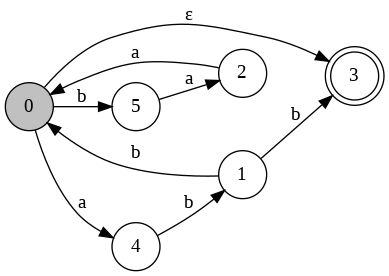

In [68]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/content/nfa.gv.png')
img

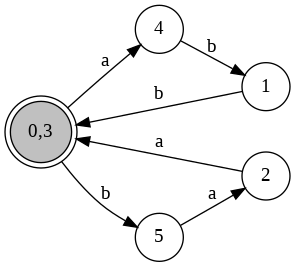

In [57]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/content/dfa.gv.png')
img

In [62]:
if __name__ == '__main__':
    text = '''1 2 3 4 5
a b
0
4
0 a 2
0 empty 1
1 a 3
2 b 3
1 a 4
3 a 4
3 b 4'''
    nfa = NFA.from_text(text)
    nfa.draw()
    print(nfa.to_grammar().to_string())

A B C D E
a b
A
A -> aC
B -> aE|aD
C -> bD
D -> aE|bE
E -> ε



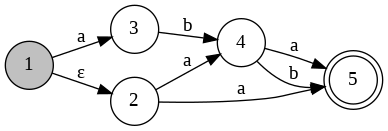

In [63]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/content/nfa.gv.png')
img